$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# import libraries
import os
import numpy as np
import sys
import logging
import os.path as path
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import ccapt_tools, leap_tools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
 %reload_ext autoreload

In [4]:
# Disable showing logging in Jupyter notebook
logging.disable(sys.maxsize)

In [5]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [15]:
# check pytables library and install it
try:
    import tables
except:
    !conda install --yes --prefix {sys.prefix} pytables

In [16]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof, max_mc = wd.dataset_tdc_selection()
display(tdc, pulse_mode, max_tof, flightPathLength_d, det_diam,  t0_d, max_mc)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

IntText(value=5000, description='Max tof:')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=78.0, description='Detector diameter:')

FloatText(value=54.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

$\text{Path to the dataset}$

In [17]:

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/load_crop/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
        
# dataset name
filename = dataset_path
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dld_group_storage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc.value, pulse_mode=pulse_mode.value, max_tof=max_tof.value, det_diam=det_diam.value)

print('Total number of Ions:', len(dld_group_storage))

Filename>> C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/OLO_Ni_8_data.h5
{'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 2000205


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

In [18]:
dld_group_storage

,high_voltage (V),pulse (V),start_counter,t (ns),x_det (cm),y_det (cm)
0,500.000000,500.000000,22040.0,3811.648968,0.487102,-2.091673
1,500.000000,500.000000,38554.0,161.156142,2.047102,-1.731918
2,500.757996,500.757996,50094.0,3993.248808,2.107592,1.041061
3,501.893494,501.893494,30014.0,3408.302556,1.961143,0.302449
4,503.027496,503.027496,5742.0,2503.218006,-1.493143,-2.117143
...,...,...,...,...,...,...
2000200,6329.835938,6329.835938,58904.0,610.183692,-0.318367,-3.084980
2000201,6329.835938,6329.835938,58932.0,630.764550,3.451102,0.210122
2000202,6329.835938,6329.835938,59312.0,592.352892,0.257878,-0.773633
2000203,6329.835938,6329.835938,59473.0,609.998526,2.113959,1.499510


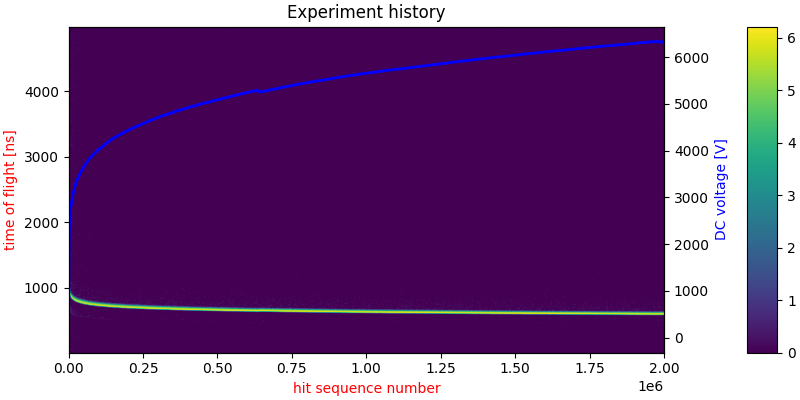

In [19]:
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, save_name = variables.result_path + '//ex_hist_' + dataset_name)

$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [20]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_group_storage)

Min Idx: 66231.46359248343 Max Idx: 1984168.4449555743


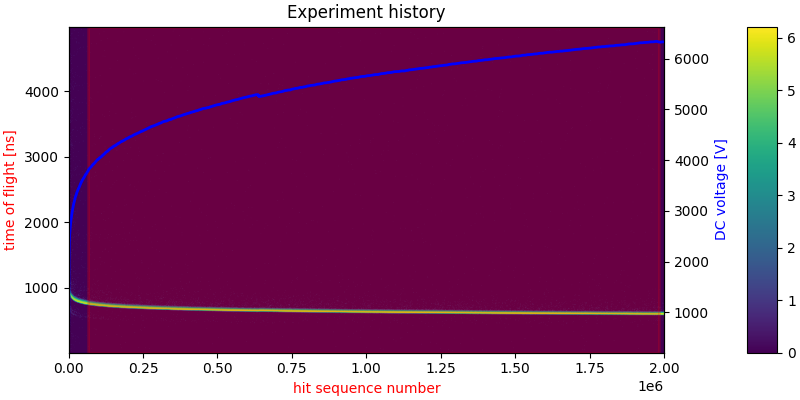

In [21]:
# Plot and selected experiment history
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

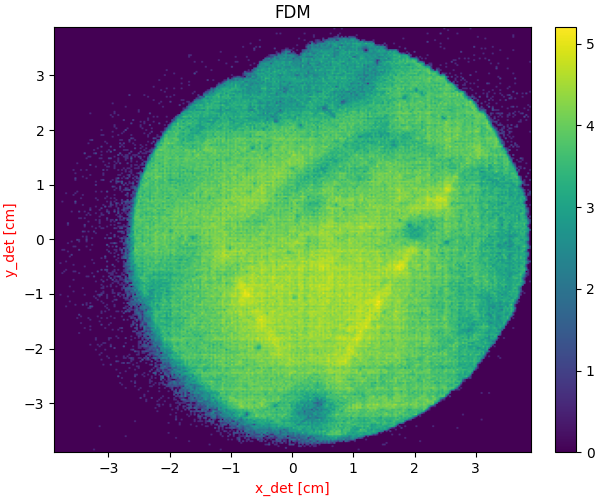

In [22]:
# Plot and select the FDM
data_loadcrop.plot_crop_FDM(data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

x: 0.618774535498686 y: -0.19042489311322797 roi: 3.1265766693686645


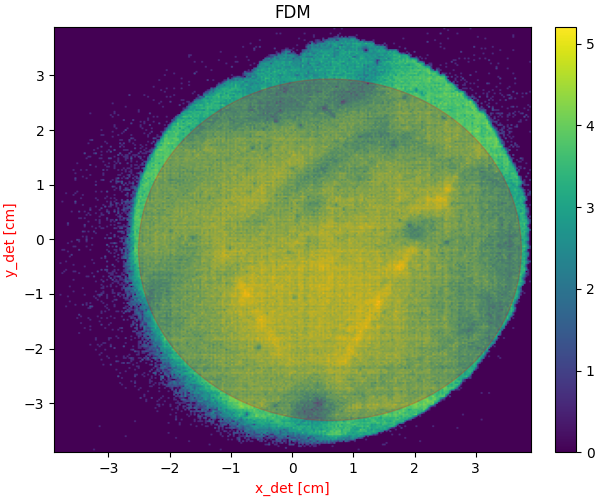

In [24]:
# plot selected area in FDM
data_loadcrop.plot_crop_FDM(data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name, circle=True)

$\text {The final selected data after processing is shown below.}$

c:\users\mehrp\pycharmprojects\pyccapt\pyccapt\calibration\calibration_tools\data_loadcrop.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop.drop(np.where(mask_fdm)[0], inplace=True)


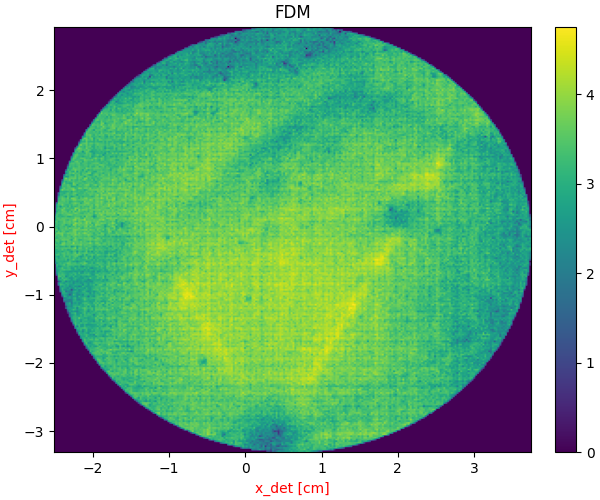

In [25]:
# Crop and plot the dataset
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_crop_FDM(data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name, only_plot=True)

In [26]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM['start_counter'].to_numpy()

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped dataset
data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


C:\Users\mehrp\AppData\Local\Temp\ipykernel_66464\3416479450.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
C:\Users\mehrp\AppData\Local\Temp\ipykernel_66464\3416479450.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [27]:
# save the cropped data

print('tof Crop Loss {:.2f} %'.format(((1 - len(data_crop_FDM) / len(dld_group_storage)) * 100)))

tof Crop Loss 13.66 %


In [28]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data_crop_FDM['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data_crop_FDM['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data_crop_FDM['pulse (deg)'].to_numpy()
dld_t = data_crop_FDM['t (ns)'].to_numpy()
dld_x = data_crop_FDM['x_det (cm)'].to_numpy()
dld_y = data_crop_FDM['y_det (cm)'].to_numpy()

mc_seb_ini = mc_tools.tof2mc(dld_t, t0_d.value, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_d.value, mode=pulse_mode.value)

data_crop_FDM.insert(0, 'x (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(1, 'y (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(2,'z (nm)', np.zeros(len(mc_seb_ini)))

data_crop_FDM.insert(3,'mc_c (Da)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(4, 'mc (Da)', mc_seb_ini)

data_crop_FDM.insert(9,'t_c (nm)', np.zeros(len(mc_seb_ini)))

In [29]:
# Remove the data with mc biger thatn 400
mask = (data_crop_FDM['mc (Da)'].to_numpy() > max_mc.value)
print('The number of data over max_mc:', len(mask[mask==True]))
data_crop_FDM.drop(np.where(mask)[0], inplace=True)
data_crop_FDM.reset_index(inplace=True, drop=True)

The number of data over max_mc: 20273


C:\Users\mehrp\AppData\Local\Temp\ipykernel_66464\2594199460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM.drop(np.where(mask)[0], inplace=True)


In [30]:
data_crop_FDM

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,29.371077,3796.077393,3796.077393,45954.0,767.252466,0.0,-1.677796,1.712816,0,1
1,0.0,0.0,0.0,0.0,29.625097,3796.077393,3796.077393,46101.0,762.582168,0.0,-1.254367,1.203429,147,1
2,0.0,0.0,0.0,0.0,30.548003,3796.077393,3796.077393,46138.0,767.417058,0.0,-0.550776,0.786367,37,1
3,0.0,0.0,0.0,0.0,29.513562,3796.077393,3796.077393,46766.0,763.089660,0.0,-1.133388,1.544082,628,1
4,0.0,0.0,0.0,0.0,28.428452,3796.077393,3796.077393,46793.0,756.444258,0.0,2.308163,-0.827755,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706653,0.0,0.0,0.0,0.0,30.404092,6323.856445,6323.856445,54965.0,613.983024,0.0,1.509061,-1.566367,389,1
1706654,0.0,0.0,0.0,0.0,29.509248,6323.856445,6323.856445,55577.0,600.712794,0.0,-1.391265,-0.735429,612,1
1706655,0.0,0.0,0.0,0.0,30.152574,6323.856445,6323.856445,56100.0,613.832148,0.0,-0.977388,-2.180816,523,1
1706656,0.0,0.0,0.0,0.0,29.356131,6323.856445,6323.856445,56141.0,597.009474,0.0,0.108245,1.197061,41,1


In [31]:
data_crop_FDM.dtypes

x (nm)              float64
y (nm)              float64
z (nm)              float64
mc_c (Da)           float64
mc (Da)             float64
high_voltage (V)    float64
pulse (V)           float64
start_counter       float64
t (ns)              float64
t_c (nm)            float64
x_det (cm)          float64
y_det (cm)          float64
pulse_pi             uint32
ion_pp               uint32
dtype: object

In [32]:
# save the dataset to hdf5 file
hierarchyName = 'df'
data_tools.store_df_to_hdf(savename, data_crop_FDM, hierarchyName)

In [24]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.pos')

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_crop_FDM, variables.result_path + dataset_name + '.csv')